In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from tqdm import tqdm

In [3]:
from neural_networks import feedforward

Consider the operator 
$$
G : D\in [D_{min}, D_{max}] \mapsto \mathbf{u}_D
$$
where $\mathbf{u}$ is the solution of the parametric heat equation 
$$
D\Delta \mathbf{u} = 1
$$

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
nx = 100

In [6]:
layers = [1] + 3*[nx] + [nx]
activations = 'tanh'

In [8]:
model = feedforward(layers, activations, seed=123)

feedforward(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
)
device : cuda


In [9]:
def loss_fn(x, y = 0):
    return torch.square(y - x).mean()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Training data :

In [11]:
def chaleur(nx, D) :
    
    x = np.linspace(0, 1, nx)
    dx = 1/(nx - 1)
    A = -2 * np.eye(nx) + np.eye(nx, k = -1) + np.eye(nx, k = 1) 
    b = - (dx**2 / D)* np.ones(nx)
    
    return x, np.linalg.solve(A, b)

In [12]:
D = np.linspace(0.1, 1, 1000)

In [13]:
%%time

U = []

for d in D : 
    x, u = chaleur(nx, d)
    U.append(u)

CPU times: user 87.1 ms, sys: 0 ns, total: 87.1 ms
Wall time: 86.8 ms


In [14]:
U = np.stack(U)
U.shape

(1000, 100)

In [15]:
D = torch.Tensor(D).view(-1, 1).to(device)
U = torch.Tensor(U).to(device)

# Training

In [16]:
num_epochs = 10000

In [17]:
log = []

In [18]:
%%time

loading_bar = tqdm(range(num_epochs + 1), colour = 'blue')

for ep in loading_bar :
    
    U_pred = model(D)
    
    loss = loss_fn(U_pred, U)
    
    loss.backward()

    optimizer.step()

    optimizer.zero_grad()
    
    log.append(loss.item())
    
    loading_bar.set_description('loss : %.2e'%(log[-1]))
    
    #if ep % 1000 == 0 :
        #tqdm.write('epoch %d, loss: %.2e' %(ep, loss.item()))

loss : 1.34e-06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [00:15<00:00, 650.17it/s]

CPU times: user 15.3 s, sys: 1.13 s, total: 16.5 s
Wall time: 15.4 s


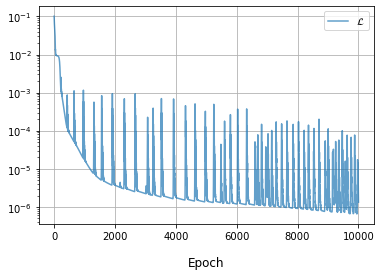

In [20]:
fig, ax = plt.subplots(1, 1)

ax.grid(True)
ax.set_yscale('log')
ax.set_xlabel('Epoch', fontsize = 12, labelpad=15)
#ax.ticklabel_format(style='sci', axis='x', scilimits=(3, 3))

ax.plot(log, label = '$\mathcal{L}$', alpha=.7)

ax.legend()
#plt.savefig('losse.pdf', bbox_inches ='tight')
plt.show()

In [21]:
U_pred = model(D).detach().cpu()
U = U.detach().cpu()

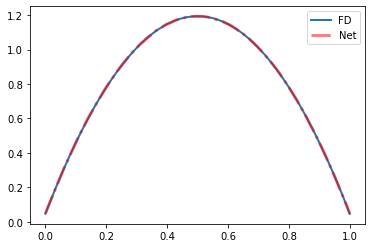

In [22]:
i = 10

plt.plot(x, U[i], lw = 2, label = 'FD ')
plt.plot(x, U_pred[i], 'r-.', lw = 3, alpha = .5, label = 'Net')

plt.legend()
plt.show()

In [23]:
D_ = torch.tensor([2.], device = device)
u_pred = model(D_)

In [24]:
x, u = chaleur(nx, 2.) 

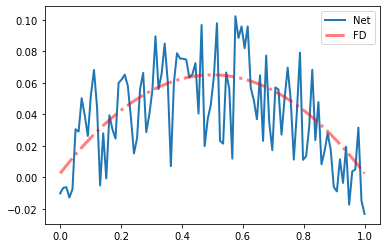

In [25]:
plt.plot(x, u_pred.detach().cpu(), lw = 2, label = 'Net')
plt.plot(x, u, 'r-.', lw = 3, alpha = .5, label = 'FD')

plt.legend()
plt.show()